In [1]:
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [2]:
df = pd.read_excel("dataset.xlsx", sheet_name=None, header=0)
all_df = {}
for i, d in enumerate(df.items()):
    name, data = d
    data['wellid'] = i
    all_df[name] = data

In [3]:
data = all_df['1K-01']
data = data[data['DEPTH'] == data["DEPTH"]]   # drop NaN value row
data = data.drop(["Core_Facies"], axis=1)
comb = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
def label_facies(row):
    f = row['Fluid']
    lf = row['Log_Facies']
    return comb.index((f, lf)) + 1
data['MixLabel'] = data.apply(label_facies, axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler

## by categories 

In [5]:
X = data[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
ss = StandardScaler()
X = ss.fit_transform(X)
Y = data['MixLabel']

data_test = all_df['1X-02']
data_test = data_test[data_test['DEPTH'] == data_test["DEPTH"]]  
data_test = data_test.drop(["Core_Facies"], axis=1)

data_test['MixLabel'] = data_test.apply(label_facies, axis=1)
X_test = data_test[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
X_test = ss.transform(X_test)
Y_test = data_test['MixLabel']

In [6]:
# 这个格子不注释 就是用cross validation , 并且取消下面cross validation的注释



data = pd.concat(df.values())
data = data[data['DEPTH'] == data["DEPTH"]]   # drop NaN value row

data['Log_Facies'] = data['Log_Facies'].apply(lambda x: int(x))
comb = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
def label_facies(row):
    f = row['Fluid']
    lf = row['Log_Facies']
    return comb.index((f, lf))
data['MixLabel'] = data.apply(label_facies, axis=1)

from sklearn.model_selection import StratifiedShuffleSplit

num_of_shuffler = 1
X = data[["DEPTH", "DT", "GR", "LLD", "NPHI", "RHOB"]]
OX = X
OY = data['MixLabel']
Y = data['MixLabel']


shuffler1 = StratifiedShuffleSplit(n_splits=num_of_shuffler, test_size=0.1, random_state=0).split(X, Y)
s1 = [x for x in shuffler1]
indices1 = [(train_idx, validation_idx) for train_idx, validation_idx in s1]



X_train = OX.values[indices1[0][0]]
ss = StandardScaler()
X = ss.fit_transform(X_train)
X_test = OX.values[indices1[0][1]]
X_test = ss.transform(X_test)
Y = data['MixLabel'].values[indices1[0][0]]
Y_test = data['MixLabel'].values[indices1[0][1]]


In [7]:
# 这个格子不注释 就是用cross well , 并且取消下面cross well的注释

# data = pd.concat(df.values())
# data = data[data['DEPTH'] == data["DEPTH"]]   # drop NaN value row

# data['Log_Facies'] = data['Log_Facies'].apply(lambda x: int(x))
# comb = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
# def label_facies(row):
#     f = row['Fluid']
#     lf = row['Log_Facies']
#     return comb.index((f, lf))
# data['MixLabel'] = data.apply(label_facies, axis=1)

# from sklearn.model_selection import StratifiedShuffleSplit

# num_of_shuffler = 1
# X = data[["DEPTH", "DT", "GR", "LLD", "NPHI", "RHOB"]]
# OX = X
# OY = data['MixLabel']
# Y = data['MixLabel']
# data = data.reset_index()

# well_index = 2
# train_index = data[data['wellid']!=well_index].index
# test_index = data[data['wellid']==well_index].index
# indices1 = [[train_index, test_index]]


# X_train = OX.values[indices1[0][0]]
# ss = StandardScaler()
# X = ss.fit_transform(X_train)
# X_test = OX.values[indices1[0][1]]
# X_test = ss.transform(X_test)
# Y = data['MixLabel'].values[indices1[0][0]]
# Y_test = data['MixLabel'].values[indices1[0][1]]

In [8]:
from sklearn.cluster import KMeans

In [9]:
model = KMeans(n_clusters=5)
Y_pred = model.fit_predict(X)

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
cluster_mapping = {}
for i in set(Y):
#     print(i, pd.Series(Y_pred[Y==i]).apply(lambda x: str(x)).describe())
#     print(i, pd.Series(Y_pred[Y==i]).apply(lambda x: str(x)).value_counts())
#     print("#######")
    print("cluster", i)
    print(pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts())
    most_ = pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts().to_dict()
    most_ = max(most_.items(), key=lambda x: x[1])[0]
    cluster_mapping[i] = int(most_)
cluster_mapping
#     print("####################")

cluster 0
1    363
3    327
4    215
0    180
2    168
dtype: int64
cluster 1
0    50
1    21
2    21
dtype: int64
cluster 2
3    747
4    500
0     28
2      9
1      9
dtype: int64
cluster 3
3    868
0    136
4     98
1     76
2     15
dtype: int64
cluster 4
0    214
3    116
1     33
2     26
4      5
dtype: int64


{0: 1, 1: 0, 2: 3, 3: 3, 4: 0}

In [12]:
Y_test_pred = model.predict(X_test)
Y_test_pred_mapping = pd.Series(Y_test_pred).apply(lambda x: cluster_mapping[x])

total = Y_test[Y_test_pred_mapping==Y_test].shape[0]
print(total, Y_test.shape[0], total/Y_test.shape[0])

for i in set(cluster_mapping.keys()):
    
    print("cluster", i)
    print(pd.Series(Y_test[Y_test_pred==i]).apply(lambda x: str(x)).value_counts())
    
    tmp = Y_test_pred_mapping[Y_test_pred==i]
    tmp2 = Y_test[Y_test_pred==i]
    
    tmp1 = tmp[tmp==tmp2]
    print("total: {}, correct:{}, rate:{:.4f}".format(tmp.shape[0], tmp1.shape[0], tmp1.shape[0]/tmp.shape[0] if tmp.shape[0]!=0 else -1 ))
    
print("mapping", cluster_mapping)

244 470 0.5191489361702127
cluster 0
1    37
3    36
0    24
4    19
2    16
dtype: int64
total: 132, correct:37, rate:0.2803
cluster 1
0    4
1    2
2    1
dtype: int64
total: 7, correct:4, rate:0.5714
cluster 2
3    81
4    63
2     4
1     1
0     1
dtype: int64
total: 150, correct:81, rate:0.5400
cluster 3
3    102
0     18
1     12
4      9
2      3
dtype: int64
total: 144, correct:102, rate:0.7083
cluster 4
0    20
3    10
1     4
2     3
dtype: int64
total: 37, correct:20, rate:0.5405
mapping {0: 1, 1: 0, 2: 3, 3: 3, 4: 0}


## by categories 2

In [13]:
model = KMeans(n_clusters=2)


Y = data['Fluid']
Y_test = data_test['Fluid']


# cross validation
Y = data['Fluid'].values[indices1[0][0]]
Y_test = data['Fluid'].values[indices1[0][1]]



Y_pred = model.fit_predict(X)
cluster_mapping = {}
for i in set(Y_pred):
    print("cluster", i)
    print(pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts())
    most_ = pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts().to_dict()
    most_ = max(most_.items(), key=lambda x: x[1])[0]
    cluster_mapping[i] = int(most_)
cluster_mapping

cluster 0
2    1661
1     498
dtype: int64
cluster 1
2    1215
1     851
dtype: int64


{0: 2, 1: 2}

In [14]:

Y_test_pred = model.predict(X_test)
Y_test_pred_mapping = pd.Series(Y_test_pred).apply(lambda x: cluster_mapping[x])

total = Y_test[Y_test_pred_mapping==Y_test].shape[0]
print(total, Y_test.shape[0], total/Y_test.shape[0])

for i in set(cluster_mapping.keys()):
    
    print("cluster", i)
    print(pd.Series(Y_test[Y_test_pred==i]).apply(lambda x: str(x)).value_counts())
    
    tmp = Y_test_pred_mapping[Y_test_pred==i]
    tmp2 = Y_test[Y_test_pred==i]
    
    tmp1 = tmp[tmp==tmp2]
    print("total: {}, correct:{}, rate:{:.4f}".format(tmp.shape[0], tmp1.shape[0], tmp1.shape[0]/tmp.shape[0]) )
    
print("mapping", cluster_mapping)

320 470 0.6808510638297872
cluster 0
2    181
1     51
dtype: int64
total: 232, correct:181, rate:0.7802
cluster 1
2    139
1     99
dtype: int64
total: 238, correct:139, rate:0.5840
mapping {0: 2, 1: 2}


## by categories 3

In [15]:
model = KMeans(n_clusters=3)
Y = data['Log_Facies'].apply(lambda x: int(x))
Y_test = data_test['Log_Facies'].apply(lambda x: int(x))


# cross validation
Y = data['Log_Facies'].values[indices1[0][0]]
Y_test = data['Log_Facies'].values[indices1[0][1]]


Y_pred = model.fit_predict(X)
cluster_mapping = {}
for i in set(Y_pred):
    print("cluster", i)
    print(pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts())
    most_ = pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts().to_dict()
    most_ = max(most_.items(), key=lambda x: x[1])[0]
    cluster_mapping[i] = int(most_)
cluster_mapping

cluster 0
1    1019
2     871
3     107
dtype: int64
cluster 1
1    1309
2     411
3     106
dtype: int64
cluster 2
1    338
2     38
3     26
dtype: int64


{0: 1, 1: 1, 2: 1}

In [16]:

Y_test_pred = model.predict(X_test)
Y_test_pred_mapping = pd.Series(Y_test_pred).apply(lambda x: cluster_mapping[x])

total = Y_test[Y_test_pred_mapping==Y_test].shape[0]
print(total, Y_test.shape[0], total/Y_test.shape[0])

for i in set(cluster_mapping.keys()):
    
    print("cluster", i)
    print(pd.Series(Y_test[Y_test_pred==i]).apply(lambda x: str(x)).value_counts())
    
    tmp = Y_test_pred_mapping[Y_test_pred==i]
    tmp2 = Y_test[Y_test_pred==i]
    
    tmp1 = tmp[tmp==tmp2]
    print("total: {}, correct:{}, rate:{:.4f}".format(tmp.shape[0], tmp1.shape[0], tmp1.shape[0]/tmp.shape[0] if tmp.shape[0]!=0 else -1) )
    
print("mapping", cluster_mapping)

296 470 0.6297872340425532
cluster 0
1    109
2     91
3      8
dtype: int64
total: 208, correct:109, rate:0.5240
cluster 1
1    156
2     52
3     16
dtype: int64
total: 224, correct:156, rate:0.6964
cluster 2
1    31
2     4
3     3
dtype: int64
total: 38, correct:31, rate:0.8158
mapping {0: 1, 1: 1, 2: 1}


## Clustering number selection (by the best K number)

In [17]:
d = []
r = [i for i in range(2, 15)]
for i in r:
    model = KMeans(n_clusters=i)
    model.fit(X)
    d.append(model.inertia_)

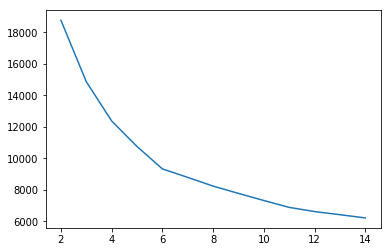

In [18]:
plt.plot(r, d)

In [19]:
from pprint import pprint
for i, n in enumerate(r):
    print(n, d[i])

2 18772.843570506204
3 14867.14050538675
4 12373.07555933562
5 10749.769482913043
6 9326.164742750178
7 8785.174208707836
8 8232.347579220328
9 7768.234745428435
10 7316.35364078796
11 6879.527838282069
12 6613.784196322178
13 6415.120639326117
14 6209.912652103114


In [20]:
model = KMeans(n_clusters=6)

# Y = data['Log_Facies'].apply(lambda x: int(x))
# Y_test = data_test['Log_Facies'].apply(lambda x: int(x))

# cross validation
Y = data['Log_Facies'].values[indices1[0][0]]
Y_test = data['Log_Facies'].values[indices1[0][1]]


Y_pred = model.fit_predict(X)
cluster_mapping = {}
for i in set(Y_pred):
#     print("cluster", i)
#     print(pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts())
    most_ = pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts().to_dict()
    most_ = max(most_.items(), key=lambda x: x[1])[0]
    cluster_mapping[i] = int(most_)
# cluster_mapping

Y_test_pred = model.predict(X_test)
Y_test_pred_mapping = pd.Series(Y_test_pred).apply(lambda x: cluster_mapping[x])

total = Y_test[Y_test_pred_mapping==Y_test].shape[0]
print(total, Y_test.shape[0], total/Y_test.shape[0])

for i in set(cluster_mapping.keys()):
    
    print("cluster", i)
    print(pd.Series(Y_test[Y_test_pred==i]).apply(lambda x: str(x)).value_counts())
    
    tmp = Y_test_pred_mapping[Y_test_pred==i]
    tmp2 = Y_test[Y_test_pred==i]
    
    tmp1 = tmp[tmp==tmp2]
    print("total: {}, correct:{}, rate:{:.4f}".format(tmp.shape[0], tmp1.shape[0], tmp1.shape[0]/tmp.shape[0] if tmp.shape[0]!=0 else -1) )
    
print("mapping", cluster_mapping)

313 470 0.6659574468085107
cluster 0
1    30
2     4
3     3
dtype: int64
total: 37, correct:30, rate:0.8108
cluster 1
2    46
1    45
3     4
dtype: int64
total: 95, correct:45, rate:0.4737
cluster 2
1    116
2     33
dtype: int64
total: 149, correct:116, rate:0.7785
cluster 3
1    71
2    16
3     4
dtype: int64
total: 91, correct:71, rate:0.7802
cluster 4
2    47
1    30
3    15
dtype: int64
total: 92, correct:47, rate:0.5109
cluster 5
1    4
2    1
3    1
dtype: int64
total: 6, correct:4, rate:0.6667
mapping {0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1}


In [21]:
model = KMeans(n_clusters=6)

# Y = data['Log_Facies'].apply(lambda x: int(x))
# Y_test = data_test['Log_Facies'].apply(lambda x: int(x))

# cross validation
Y = data['Fluid'].values[indices1[0][0]]
Y_test = data['Fluid'].values[indices1[0][1]]


Y_pred = model.fit_predict(X)
cluster_mapping = {}
for i in set(Y_pred):
#     print("cluster", i)
#     print(pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts())
    most_ = pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts().to_dict()
    most_ = max(most_.items(), key=lambda x: x[1])[0]
    cluster_mapping[i] = int(most_)
# cluster_mapping

Y_test_pred = model.predict(X_test)
Y_test_pred_mapping = pd.Series(Y_test_pred).apply(lambda x: cluster_mapping[x])

total = Y_test[Y_test_pred_mapping==Y_test].shape[0]
print(total, Y_test.shape[0], total/Y_test.shape[0])

for i in set(cluster_mapping.keys()):
    
    print("cluster", i)
    print(pd.Series(Y_test[Y_test_pred==i]).apply(lambda x: str(x)).value_counts())
    
    tmp = Y_test_pred_mapping[Y_test_pred==i]
    tmp2 = Y_test[Y_test_pred==i]
    
    tmp1 = tmp[tmp==tmp2]
    print("total: {}, correct:{}, rate:{:.4f}".format(tmp.shape[0], tmp1.shape[0], tmp1.shape[0]/tmp.shape[0] if tmp.shape[0]!=0 else -1) )
    
print("mapping", cluster_mapping)

401 470 0.8531914893617021
cluster 0
2    88
1     7
dtype: int64
total: 95, correct:88, rate:0.9263
cluster 1
1    75
2    17
dtype: int64
total: 92, correct:75, rate:0.8152
cluster 2
2    57
1    34
dtype: int64
total: 91, correct:57, rate:0.6264
cluster 3
1    27
2    10
dtype: int64
total: 37, correct:27, rate:0.7297
cluster 4
2    148
1      1
dtype: int64
total: 149, correct:148, rate:0.9933
cluster 5
1    6
dtype: int64
total: 6, correct:6, rate:1.0000
mapping {0: 2, 1: 1, 2: 2, 3: 1, 4: 2, 5: 1}


In [22]:
model = KMeans(n_clusters=6)

# Y = data['Log_Facies'].apply(lambda x: int(x))
# Y_test = data_test['Log_Facies'].apply(lambda x: int(x))

# cross validation
Y = data['MixLabel'].values[indices1[0][0]]
Y_test = data['MixLabel'].values[indices1[0][1]]


Y_pred = model.fit_predict(X)
cluster_mapping = {}
for i in set(Y_pred):
#     print("cluster", i)
#     print(pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts())
    most_ = pd.Series(Y[Y_pred==i]).apply(lambda x: str(x)).value_counts().to_dict()
    most_ = max(most_.items(), key=lambda x: x[1])[0]
    cluster_mapping[i] = int(most_)
# cluster_mapping

Y_test_pred = model.predict(X_test)
Y_test_pred_mapping = pd.Series(Y_test_pred).apply(lambda x: cluster_mapping[x])

total = Y_test[Y_test_pred_mapping==Y_test].shape[0]
print(total, Y_test.shape[0], total/Y_test.shape[0])

for i in set(cluster_mapping.keys()):
    
    print("cluster", i)
    print(pd.Series(Y_test[Y_test_pred==i]).apply(lambda x: str(x)).value_counts())
    
    tmp = Y_test_pred_mapping[Y_test_pred==i]
    tmp2 = Y_test[Y_test_pred==i]
    
    tmp1 = tmp[tmp==tmp2]
    print("total: {}, correct:{}, rate:{:.4f}".format(tmp.shape[0], tmp1.shape[0], tmp1.shape[0]/tmp.shape[0] if tmp.shape[0]!=0 else -1) )
print("mapping", cluster_mapping)

273 470 0.5808510638297872
cluster 0
0    4
2    1
1    1
dtype: int64
total: 6, correct:4, rate:0.6667
cluster 1
3    115
4     33
0      1
dtype: int64
total: 149, correct:115, rate:0.7718
cluster 2
0    20
3    10
1     4
2     3
dtype: int64
total: 37, correct:20, rate:0.5405
cluster 3
3    53
0    18
1    12
4     4
2     4
dtype: int64
total: 91, correct:53, rate:0.5824
cluster 4
3    44
4    44
2     4
1     2
0     1
dtype: int64
total: 95, correct:44, rate:0.4632
cluster 5
1    37
0    23
2    15
4    10
3     7
dtype: int64
total: 92, correct:37, rate:0.4022
mapping {0: 0, 1: 3, 2: 0, 3: 3, 4: 3, 5: 1}
